In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import seaborn as sns


Note: import downsample

In [2]:
def downsample(images, mask, weights=None, verbose=False, mingood=1):
    """
    Resample (average) a list of 2d images at 2x2, taking account of a logical mask

    Now optionally use a weights array, and resample that too (adding, not averaging)
    """
    # Construct slices for even and odd elements, respectively
    # e, o = np.s_[:,-1,2], np.s_[1,:,2] # Just learnt about the np.s_() function!
    e, o = slice(None,-1,2), slice(1,None,2)

    # Find the number of good sub-pixels in each new pixel
    ngood = mask[e,e].astype(int) + mask[o,e].astype(int) \
            + mask[e,o].astype(int) + mask[o,o].astype(int)
    

    newmask = ngood >= mingood
    # # Resample the mask
    # # newmask is True if any of the 4 sub-pixels are true
    # newmask = mask[e,e] | mask[o,e] | mask[e,o] | mask[o,o]

    if weights is None:
        # now resample the images
        newimages = [
            np.where(
                newmask,      # Check that we have at least 1 good pixel
                # Take the mean of all the good sub-pixels
                (image[e,e]*mask[e,e] + image[o,e]*mask[o,e]
                 + image[e,o]*mask[e,o] + image[o,o]*mask[o,o]) / ngood,
                0.0                 # Avoid NaNs if we have no good pixels
                )
            for image in images]
    else:
        newweights = (weights[e,e]*mask[e,e] + weights[o,e]*mask[o,e]
			+ weights[e,o]*mask[e,o] + weights[o,o]*mask[o,o])
        newimages = [
            np.where(
                newweights > 0.0,      # Check that we have at least 1 good pixel
                # Take the mean of all the good sub-pixels
                (image[e,e]*mask[e,e]*weights[e,e] +
                 image[o,e]*mask[o,e]*weights[o,e] +
                 image[e,o]*mask[e,o]*weights[e,o] +
                 image[o,o]*mask[o,o]*weights[o,o]
                 ) / newweights,
                0.0                 # Avoid NaNs if we have no good pixels
                )
            for image in images]

    if verbose:
        print("Fraction of good pixels: old = {:.2f}, new = {:.2f}".format(
            float(mask.sum())/mask.size, float(newmask.sum())/newmask.size))
    # Of course, we will get garbage where ngood=0, but that doesn't
    # matter since newmask will be False for those pixels
    if weights is None:
        return newimages, newmask
    else:
        # New option to bin weights too
        return newimages, newmask, newweights

In [3]:
hdulist = fits.open("GAUS_Ha6562.8_060_Will.fits")

Coordinates: Will

In [4]:
vhdu = hdulist[2]

In [5]:
w = WCS(vhdu)


In [6]:
w = w.celestial

In [7]:
w.pixel_to_world

<bound method HighLevelWCSMixin.pixel_to_world of WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 84.688309  -69.105970125  
CRPIX : 220.92793852  213.660785628  
CD1_1 CD1_2  : -5.52742276729e-05  -9.66418424553e-08  
CD2_1 CD2_2  : -4.91681964084e-07  5.53153613478e-05  
NAXIS : 650  650>

In [8]:
ny, nx = vhdu.shape

In [9]:
X, Y = np.meshgrid( np.arange(nx), np.arange(ny))

In [10]:
c = w.pixel_to_world(X, Y)

Data analysis: Memory RAM needed for calculation

Note: check equation

In [11]:
ds=0
n=2**ds
x=len(X)//n
y=len(Y)//n
xy2=(x*y)**2
RAM=xy2*8/10**9
print(x,y,x*y,(x*y)**2)
print( str(RAM) +  ' GB needed to manage the SF')

650 650 422500 178506250000
1428.05 GB needed to manage the SF


Downsample

In [12]:
mingoods = [2,2,2,2]

RA

In [13]:
radeg=c.ra.degree
m=pd.notna(radeg)

In [14]:
for mingood in zip(mingoods):
 [radeg], m= downsample([radeg], m, weights=None, mingood=mingood)

Dec

In [15]:
decdeg=c.dec.degree
m=pd.notna(decdeg)

In [16]:
for mingood in zip(mingoods):
 [decdeg], m= downsample([decdeg], m, weights=None, mingood=mingood)

Velocity Downsample

In [17]:
RV=hdulist[2].data
m=pd.notna(RV)


In [18]:
for mingood in zip(mingoods):
 [RV], m= downsample([RV], m, weights=None, mingood=mingood)

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Mask

In [19]:
RVm=RV>0
radegm=radeg>0
decdegm=abs(decdeg)>0

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [20]:
rvf=RV[RVm]
raf=radeg[radegm]
decf=decdeg[decdegm]

Main DataFrame

In [21]:
RApd=pd.DataFrame(raf)
DEpd=pd.DataFrame(decf)
RVpd=pd.DataFrame(rvf)

In [22]:
df=pd.concat([RApd,DEpd,RVpd],axis=1)
df.columns = ['RAdeg', 'DEdeg', 'RVHalpha']
df.describe()

,RAdeg,DEdeg,RVHalpha
count,1600.000000,1600.000000,1372.000000
mean,84.672852,-69.100106,265.465260
std,0.028626,0.010220,15.325207
min,84.624475,-69.117509,227.566936
25%,84.648653,-69.108805,253.721229
50%,84.672851,-69.100102,264.412408
75%,84.697068,-69.091398,276.039508
max,84.721305,-69.082694,309.224468


Adjust color scale for a better fit

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


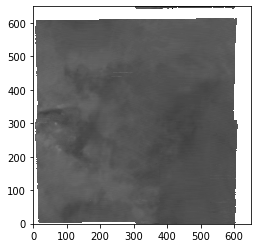

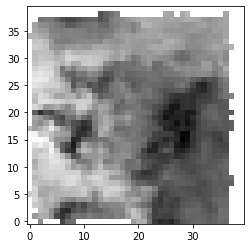

In [50]:
dataRV=hdulist[2].data
plt.figure(1)
plt.imshow(dataRV, cmap='gray')
plt.gca().invert_yaxis()
plt.figure(2)
plt.imshow(np.log10(RV), cmap='gray')
plt.gca().invert_yaxis()

Velocity Profiles

[(84.72130486120857, 84.62447474177364)]

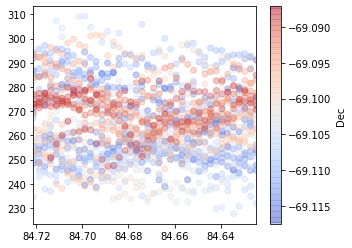

In [24]:
fig, ax = plt.subplots(figsize=(5, 4))
scat = plt.scatter(df.RAdeg, df.RVHalpha, c=df.DEdeg, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
ax.set(xlim=[df.RAdeg.max(),df.RAdeg.min()])

[(-69.08569430913063, -69.11850921161118)]

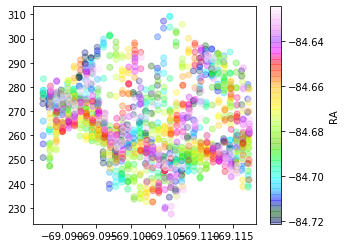

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))
scat = plt.scatter(df.DEdeg, df.RVHalpha, c=-df.RAdeg, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")
ax.set(xlim=[df.DEdeg.max()-0.003,df.DEdeg.min()-0.001])

Structure Function

In [26]:
df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.RVHalpha, '_key': 1})
df1.describe()


,RA,DE,V,_key
count,1600.000000,1600.000000,1372.000000,1600.0
mean,84.672852,-69.100106,265.465260,1.0
std,0.028626,0.010220,15.325207,0.0
min,84.624475,-69.117509,227.566936,1.0
25%,84.648653,-69.108805,253.721229,1.0
50%,84.672851,-69.100102,264.412408,1.0
75%,84.697068,-69.091398,276.039508,1.0
max,84.721305,-69.082694,309.224468,1.0


In [27]:
df2 = df1.copy()

In [28]:
pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))

pairs.head()



RA         DE           V        RA_        DE_          V_
0 0  84.721305 -69.117211  269.552244  84.721305 -69.117211  269.552244
  1  84.721305 -69.117211  269.552244  84.718824 -69.117219  248.507349
  2  84.721305 -69.117211  269.552244  84.716343 -69.117228  259.639108
  3  84.721305 -69.117211  269.552244  84.713862 -69.117236  260.351291
  4  84.721305 -69.117211  269.552244  84.711381 -69.117244  275.028657

In [29]:
pairs.loc[:, 'dDE'] = 3600*(pairs.DE - pairs.DE_)
pairs.loc[:, 'dRA'] = 3600*(pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
pairs.loc[:, 'log_s'] = np.log10(pairs.s)
pairs.loc[:, 'dV'] = pairs.V - pairs.V_
pairs.loc[:, 'dV2'] = pairs.dV**2
pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
pairs = pairs[(pairs.dDE > 0.0) & (pairs.dRA > 0.0)]
pairs.head()

RA         DE           V        RA_        DE_          V_  \
0 1  84.721305 -69.117211  269.552244  84.718824 -69.117219  248.507349   
  2  84.721305 -69.117211  269.552244  84.716343 -69.117228  259.639108   
  3  84.721305 -69.117211  269.552244  84.713862 -69.117236  260.351291   
  4  84.721305 -69.117211  269.552244  84.711381 -69.117244  275.028657   
  5  84.721305 -69.117211  269.552244  84.708900 -69.117252  281.051941   

          dDE        dRA          s     log_s         dV         dV2  \
0 1  0.029970   3.183780   3.183921  0.502962  21.044896  442.887629   
  2  0.059810   6.367562   6.367843  0.803992   9.913137   98.270277   
  3  0.089522   9.551344   9.551764  0.980084   9.200954   84.657546   
  4  0.119105  12.735128  12.735685  1.105022  -5.476413   29.991096   
  5  0.148560  15.918913  15.919607  1.201932 -11.499697  132.243026   

      log_dV2     VV_mean  
0 1  2.646294  259.029796  
  2  1.992422  264.595676  
  3  1.927666  264.951767  
  4  1.476992  272.290451  
  5  2.121373  275.302093

In [31]:
pairs.describe()

,RA,DE,V,RA_,DE_,V_,dDE,dRA,s,log_s,dV,dV2,log_dV2,VV_mean
count,639600.000000,639600.000000,478170.000000,639600.000000,639600.000000,623616.000000,639600.000000,639600.000000,639600.000000,639600.000000,477834.000000,4.778340e+05,477834.000000,477834.000000
mean,84.689764,-69.094301,267.143073,84.655931,-69.105911,263.804763,41.796239,43.450045,66.602651,1.757503,3.684617,4.640819e+02,2.108420,265.297972
std,0.023058,0.008443,14.816440,0.023071,0.008443,15.432010,30.395187,29.620650,31.625431,0.268556,21.225136,6.218522e+02,0.980521,10.906161
min,84.626952,-69.117502,227.566936,84.624475,-69.117509,227.566936,0.025072,2.902567,3.183921,0.502962,-74.747585,3.364716e-13,-12.473052,228.629907
25%,84.674037,-69.100436,256.078538,84.636908,-69.113020,252.379525,16.211785,19.020664,41.668335,1.619806,-10.133442,4.468580e+01,1.650170,257.501829
50%,84.693876,-69.092620,268.215230,84.651809,-69.107597,262.090239,35.745416,38.162697,65.585852,1.816810,4.038488,2.123273e+02,2.327006,265.103253
75%,84.708791,-69.087193,276.735520,84.671665,-69.099773,273.988372,63.882861,63.653225,89.992299,1.954205,18.296150,6.353972e+02,2.803045,272.678784
max,84.721305,-69.082694,309.224468,84.718824,-69.082703,309.224468,125.333649,124.168307,176.295804,2.246242,81.657531,6.667952e+03,3.823992,309.172018


In [32]:
pairs.corr()

,RA,DE,V,RA_,DE_,V_,dDE,dRA,s,log_s,dV,dV2,log_dV2,VV_mean
RA,1.000000,0.006771,0.118898,0.500000,0.003220,0.010405,0.003550,0.499603,0.347469,0.320578,0.069725,0.066887,0.058427,0.093679
DE,0.006771,1.000000,0.213811,0.003669,0.500000,0.045684,0.500001,0.003524,0.346045,0.317954,0.128095,-0.102531,-0.026596,0.165769
V,0.118898,0.213811,1.000000,0.059035,0.106972,0.027319,0.107023,0.058967,0.115732,0.094425,0.678094,0.205522,0.169915,0.698930
RA_,0.500000,0.003669,0.059035,1.000000,0.007007,0.020854,-0.003339,-0.500397,-0.347632,-0.320691,0.017242,0.036500,0.023489,0.063453
DE_,0.003220,0.500000,0.106972,0.007007,1.000000,0.097014,-0.499999,-0.003365,-0.345922,-0.317862,0.033110,-0.084757,-0.090058,0.112841
V_,0.010405,0.045684,0.027319,0.020854,0.097014,1.000000,-0.045681,-0.010430,-0.032044,-0.036086,-0.716176,-0.027878,-0.019234,0.734017
dDE,0.003550,0.500001,0.107023,-0.003339,-0.499999,-0.045681,1.000000,0.006889,0.691968,0.635817,0.095155,-0.018031,0.063256,0.053292
dRA,0.499603,0.003524,0.058967,-0.500397,-0.003365,-0.010430,0.006889,1.000000,0.695101,0.641269,0.051961,0.029792,0.034434,0.029535
s,0.347469,0.346045,0.115732,-0.347632,-0.345922,-0.032044,0.691968,0.695101,1.000000,0.930303,0.095358,0.005762,0.060438,0.064622
log_s,0.320578,0.317954,0.094425,-0.320691,-0.317862,-0.036086,0.635817,0.641269,0.930303,1.000000,0.085212,0.027841,0.089686,0.045535


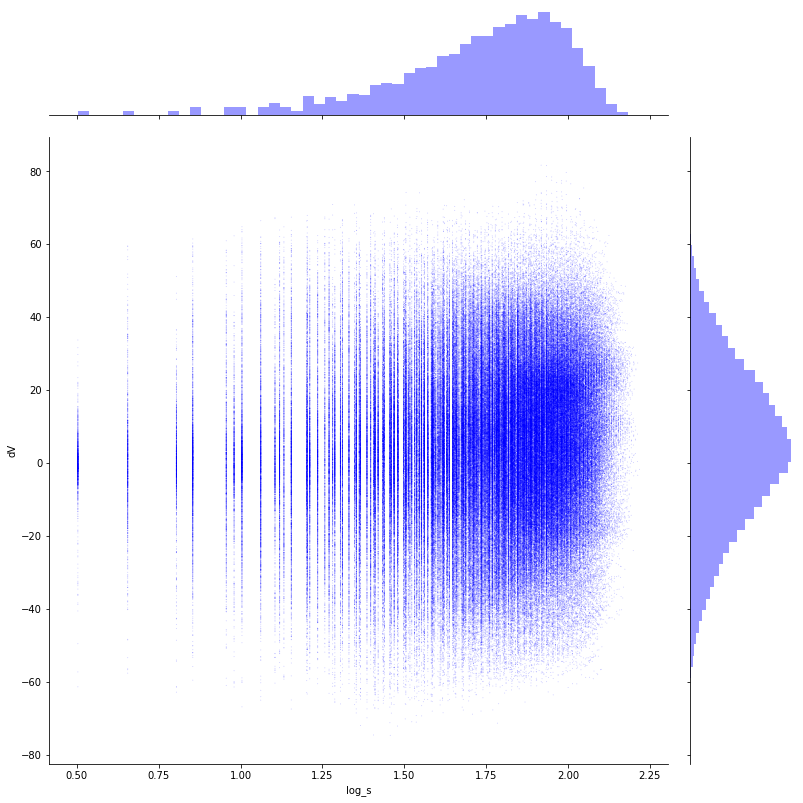

In [33]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='dV', data=pairs[mask], alpha=0.2, s=1, edgecolor='none',color="blue")
ax.fig.set_size_inches(12, 12)

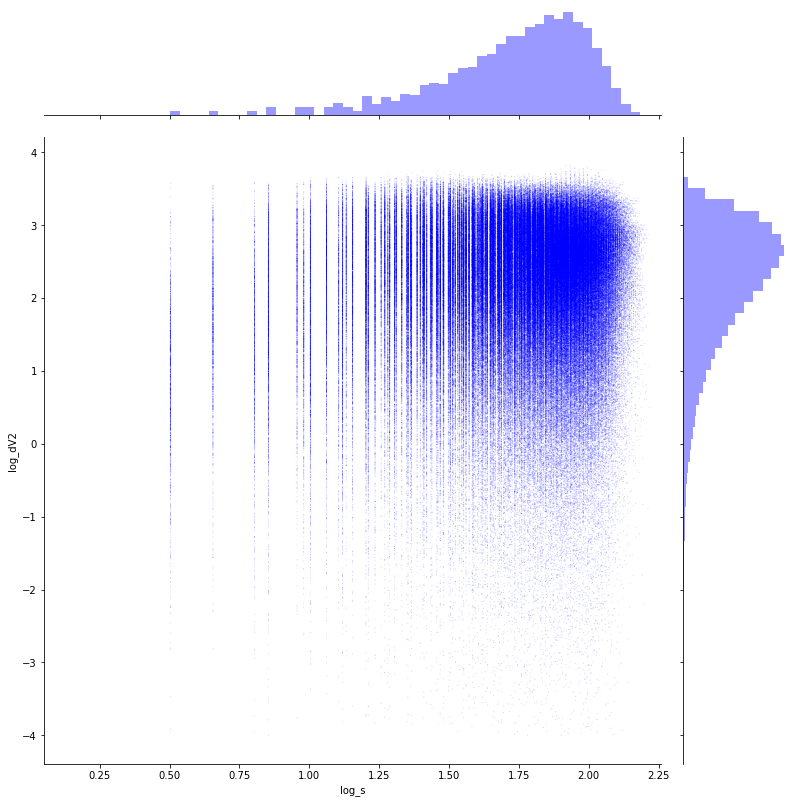

In [34]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='log_dV2', data=pairs[mask], alpha=0.2, s=1, edgecolor='none', color="blue", xlim=[0.05, 2.26])
ax.fig.set_size_inches(12, 12)



In [35]:
pairs.loc[:, 's_class'] = pd.Categorical((2*pairs.log_s + 0.5).astype('int'), ordered=True)
pairs.s_class[pairs.s_class == 0] = 1

In [36]:
for j in range(5):
    print()
    print("s_class =", j)
    print(pairs[pairs.s_class == j][['dV2', 'log_s']].describe())


s_class = 0
       dV2  log_s
count  0.0    0.0
mean   NaN    NaN
std    NaN    NaN
min    NaN    NaN
25%    NaN    NaN
50%    NaN    NaN
75%    NaN    NaN
max    NaN    NaN

s_class = 1
               dV2        log_s
count  2636.000000  3081.000000
mean    139.204831     0.578106
std     358.616820     0.076114
min       0.000009     0.502962
25%       3.857337     0.502962
50%      21.489599     0.502962
75%      95.663248     0.655177
max    3772.904287     0.655177

s_class = 2
                dV2         log_s
count  26255.000000  30913.000000
mean     367.492599      1.080190
std      612.009501      0.129561
min        0.000006      0.803992
25%       15.317788      1.003923
50%       93.351187      1.118934
75%      432.984346      1.203528
max     4607.951440      1.235493

s_class = 3
                dV2          log_s
count  1.824790e+05  221572.000000
mean   4.834027e+02       1.569927
std    6.594381e+02       0.132104
min    7.028329e-09       1.257237
25%    4.311425e+

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


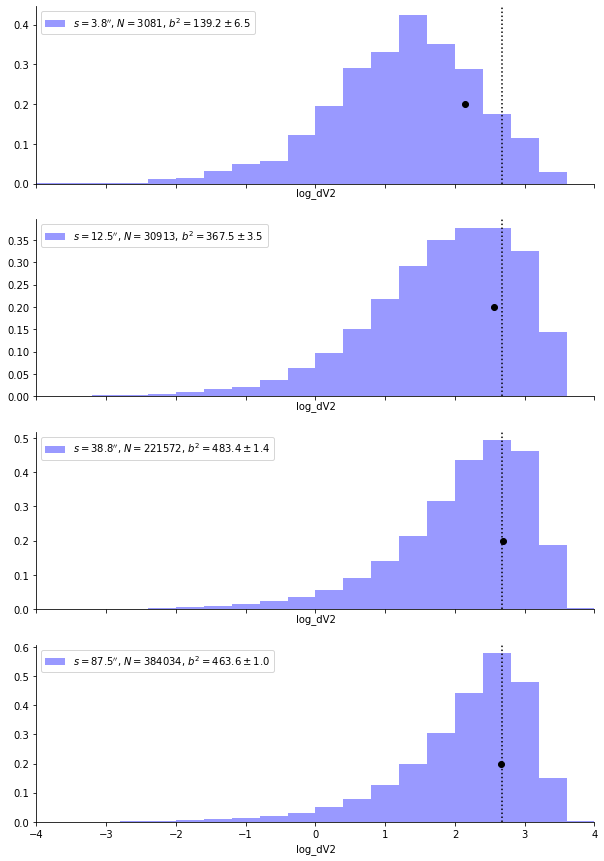

In [37]:
sig2 = pairs.dV2.mean()
sig2a = 2*np.var(df1.V)
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
for sclass, ax in zip(range(1, 5), axes):
    b2mean = np.mean(pairs.dV2[pairs.s_class == sclass])
    b2std = np.std(pairs.dV2[pairs.s_class == sclass])
    b2mean2 = np.mean(pairs.log_dV2[pairs.s_class == sclass])
    n = np.sum(pairs.s_class == sclass)
    b2sem = b2std/np.sqrt(n)
    smean = np.mean(10**pairs.log_s[pairs.s_class == sclass])
    label = f"$s = {smean:.1f}''$"
    label += f", $N = {n}$"
    label += fr", $b^2 = {b2mean:.1f} \pm {b2sem:.1f}$"
    sns.distplot(pairs.log_dV2[pairs.s_class == sclass], 
                 norm_hist=True, kde=False, ax=ax,
                 label=label, bins=20, color="blue",hist_kws=dict(range=[-4.0, 4.0])
                )
    ax.plot([np.log10(b2mean)], [0.2], 'o', color='k')
    ax.plot([np.log10(b2mean - b2sem), np.log10(b2mean + b2sem)], [0.2]*2, lw=3, color='k')
    ax.axvline(np.log10(sig2a), color='k', ls=':')
    ax.set(xlim=[-4.0, 4.0])
    ax.legend(loc='upper left')
sns.despine()

In [38]:
print(f'Dotted line is 2 x sigma^2 = {sig2a:.2f}')

Dotted line is 2 x sigma^2 = 469.38


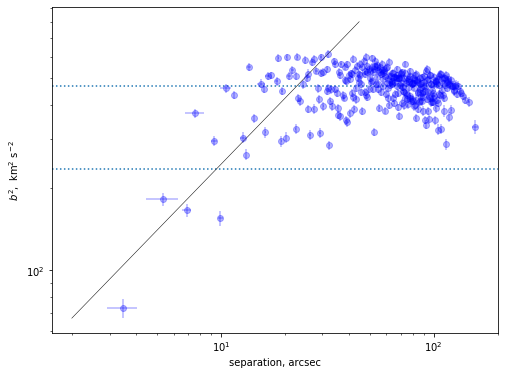

In [39]:
ngroup = 2000
groups = np.arange(len(pairs)) // ngroup
table = pairs[['s', 'dV2']].sort_values('s').groupby(groups).describe()
fig, ax = plt.subplots(figsize=(8, 6))
s = table[('s', 'mean')]
e_s = table[('s', 'std')]
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)
ax.axhline(sig2a, ls=':')
ax.axhline(0.5*sig2a, ls=':')
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.3, color="blue")
sgrid = np.logspace(0.3, 1.65)
ax.plot(sgrid, 38.5*sgrid**(0.8), color="k", lw=0.5)
ax.set(xscale='log', yscale='log', 
       xlabel='separation, arcsec',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None